In [1]:
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 34.3 MB/s 
     |████████████████████████████████| 6.6 MB 58.6 MB/s 
     |████████████████████████████████| 120 kB 70.6 MB/s 


In [2]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 26.8 MB/s 
     |████████████████████████████████| 115 kB 72.9 MB/s 
     |████████████████████████████████| 212 kB 72.2 MB/s 
     |████████████████████████████████| 127 kB 73.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Setup

In [37]:
epochs = 3
batch_size = 32
model_checkpoint = "DeepPavlov/rubert-base-cased-conversational"

In [5]:
import tensorflow as tf
import pandas as pd

from datasets import load_dataset, load_metric

#Getting and preparing data

In [137]:
emotion_labels = pd.read_csv('/content/drive/MyDrive/SentiChallenge/emotion_dict.csv', header=None)

In [138]:
emotion_labels = emotion_labels.iloc[:,0].tolist()

In [110]:
df_dev = pd.read_csv('/content/drive/MyDrive/SentiChallenge/translated/dev.tsv', sep='\t')
df_test = pd.read_csv('/content/drive/MyDrive/SentiChallenge/translated/test.tsv', sep='\t')
df_train = pd.read_csv('/content/drive/MyDrive/SentiChallenge/translated/train.tsv', sep='\t')

In [111]:
df_dev = df_dev.drop(columns=['Unnamed: 0'])
df_test = df_test.drop(columns=['Unnamed: 0'])
df_train = df_train.drop(columns=['Unnamed: 0'])

In [112]:
df_train

,text,text_ru,emotions,id
0,My favourite food is anything I didn't have to...,"Моя любимая еда - это все, что мне не приходил...",27,eebbqej
1,"Now if he does off himself, everyone will thin...","Теперь, если он покончит с собой, все подумают...",27,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,КАКОГО ХРЕНА БЭЙЛЕСС ДЕРГАЕТСЯ,2,eezlygj
3,To make her feel threatened,Чтобы заставить ее почувствовать угрозу,14,ed7ypvh
4,Dirty Southern Wankers,Грязные Южные Дрочеры,3,ed0bdzj
...,...,...,...,...
27995,"I literally teared up reading this. That poor,...","Я буквально расплакалась, читая это. Этот бедн...","0,25",efcknur
27996,Who specifically are we gonna sue? The industr...,На кого конкретно мы будем подавать в суд? Инд...,1,eeqiyt9
27997,Crack whores are hooking in broad daylight now...,"Крэк-шлюхи теперь трахаются средь бела дня, а?",7,eetfn7z
27998,Sorry if Im slow here but what does Milan or [...,"Извините, если я медлю здесь, но какое отношен...",24,efcfzbx


In [113]:
df_dev_emotions = [x.split(',') for x in df_dev['emotions'].tolist()]
df_test_emotions = [x.split(',') for x in df_test['emotions'].tolist()]
df_train_emotions = [x.split(',') for x in df_train['emotions'].tolist()]

In [114]:
import collections
collections.Counter([len(x) for x in df_dev_emotions])

Counter({1: 4548, 2: 809, 3: 62, 4: 7})

In [115]:
df_dev_emotions = [x.split(',')[0] for x in df_dev['emotions'].tolist()]
df_test_emotions = [x.split(',')[0] for x in df_test['emotions'].tolist()]
df_train_emotions = [x.split(',')[0] for x in df_train['emotions'].tolist()]

In [116]:
df_dev = df_dev.drop(columns=['text', 'id'])
df_dev['emotions'] = df_dev_emotions

df_test = df_test.drop(columns=['text', 'id'])
df_test['emotions'] = df_test_emotions

df_train = df_train.drop(columns=['text', 'id'])
df_train['emotions'] = df_train_emotions

In [117]:
df_train = df_train.append(df_dev)

In [118]:
len(df_train)

33426

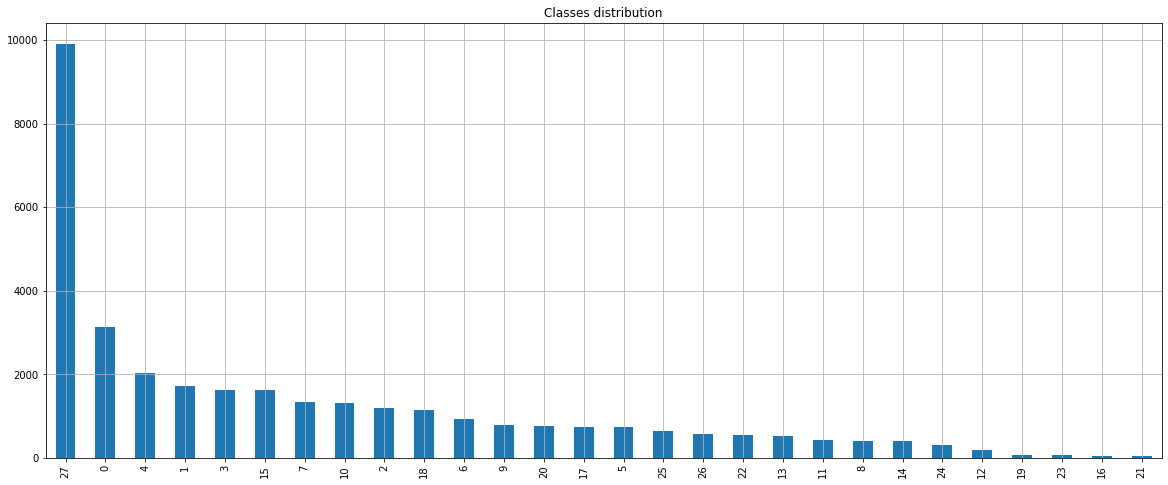

In [26]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize = (20,8))
plt.title("Classes distribution")
df_train['emotions'].value_counts().plot(kind='bar')
plt.grid()
plt.show() 

In [119]:
for x, y in df_train['emotions'].value_counts().iteritems():
  print(emotion_labels[int(x)], y)

нейтральность 9912
восхищение 3140
одобрение 2025
веселье 1734
раздражение 1639
благодарность 1639
любопытство 1352
неодобрение 1321
злость 1188
любовь 1154
замешательство 944
разочарование 786
оптимизм 765
радость 750
забота 745
грусть 657
удивление 574
реализация 547
восторг 527
отвращение 435
желание 416
страх 415
угрызение совести 313
смущение 196
нервозность 80
облегчение 72
сожаление 57
гордость 43


In [120]:
df_train

,text_ru,emotions
0,"Моя любимая еда - это все, что мне не приходил...",27
1,"Теперь, если он покончит с собой, все подумают...",27
2,КАКОГО ХРЕНА БЭЙЛЕСС ДЕРГАЕТСЯ,2
3,Чтобы заставить ее почувствовать угрозу,14
4,Грязные Южные Дрочеры,3
...,...,...
5421,"Это довольно опасно, когда государство решает,...",14
5422,"Сегодня утром я подала на развод. Надеюсь, он ...",20
5423,"В последний раз, когда это случилось, я просто...",10
5424,Я терпеть не могу этого высокомерного придурка...,3


In [121]:
df_test

,text_ru,emotions
0,Я действительно сожалею о вашей ситуации : ( Х...,25
1,"Это замечательно, потому что это ужасно. На не с.",0
2,"Фанат Kings здесь, удачи вам, ребята! Будет ин...",13
3,"Я этого не знал, спасибо тебе за то, что научи...",15
4,Им наскучило бродить по земле в течение тысяч ...,27
...,...,...
5422,Спасибо. После госпитализации мне также постав...,15
5423,"Что ж, в этом есть смысл.",4
5424,Проблемы с папой [ИМЯ],27
5425,"Так рад, что обнаружил этот субреддит пару мес...",0


In [30]:
num_labels = df_train['emotions'].nunique()
num_examples = df_train.shape[0] # row count

#Model setup

In [31]:
from transformers import BertTokenizer, TFBertForSequenceClassification, InputExample, InputFeatures, BertConfig

In [32]:
#Load tokenizer and model config
tokenizer = BertTokenizer.from_pretrained(model_checkpoint, from_pt=True)
config = BertConfig.from_pretrained(model_checkpoint, num_labels=num_labels)

In [33]:
#Load base model
model = TFBertForSequenceClassification.from_pretrained(model_checkpoint, from_pt=True, config=config)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
#Load fine-tuned model

model = TFBertForSequenceClassification.from_pretrained('/content/drive/MyDrive/SentiChallenge/checkpoints/rubert-sentiment-28CL-33K-3EP')

Some layers from the model checkpoint at /content/drive/MyDrive/SentiChallenge/checkpoints/rubert-sentiment-28CL-33K-3EP were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/SentiChallenge/checkpoints/rubert-sentiment-28CL-33K-3EP.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassifi

In [44]:
model.summary()

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  177853440 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  21532     
                                                                 
Total params: 177,874,972
Trainable params: 177,874,972
Non-trainable params: 0
_________________________________________________________________


#Converting data for input

In [35]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, 
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, 
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, validation_InputExamples
  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] 

    for e in examples:
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, 
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, 
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask,
                token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

In [36]:
DATA_COLUMN = 'text_ru'
LABEL_COLUMN = 'emotions'

train_InputExamples, validation_InputExamples = convert_data_to_examples(df_train, df_test, 
                                                                         DATA_COLUMN, LABEL_COLUMN)

# Make the CPU do all data pre-processing steps, not the GPU
with tf.device('/cpu:0'):
  train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
  train_data = train_data.shuffle(buffer_size = num_examples, reshuffle_each_iteration=True) \
                         .batch(batch_size) \
                         .repeat(-1)

  validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
  validation_data = validation_data.batch(batch_size)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


#Training

In [38]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08), 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

train_steps = num_examples // batch_size


In [39]:
history = model.fit(train_data, 
                    epochs=epochs,
                    steps_per_epoch = train_steps)

Epoch 1/3
1044/1044 [==============================] - 875s 815ms/step - loss: 1.8863 - accuracy: 0.4774
Epoch 2/3
1044/1044 [==============================] - 865s 829ms/step - loss: 1.3529 - accuracy: 0.5963
Epoch 3/3
1044/1044 [==============================] - 865s 829ms/step - loss: 0.9561 - accuracy: 0.7154


In [40]:
model.save_pretrained('/content/drive/MyDrive/SentiChallenge/checkpoints/rubert-sentiment-28CL-33K-3EP')

#Testing

In [152]:
pred_sentences = ['Ужасный сервис. Висит все утро, почините хоть что-то!',
                  'Добрый день, спасибо за быструю помощь!',
                  'Что вы собираетесь сделать по этому поводу?',
                  'Ваша служба поддержки работает чудесно',
                  'Мне ничего не понятно из вашего объяснения',
                  'Мне очень жаль что так произошло',
                  'Честно говоря, я расстроен работой вашей службы поддержки',
                  '',
                  'Да я на вас в суд подам',
                  'УРА, ВСЕ ВОССТАНОВИЛОСЬ',
                  'Надеюсь мне больше не придется сталкиваться с подобной проблемой',
                  'Обожаю то что вы делаете',
                  'Ну и сколько мне еще ждать вашего ответа, м?',
                  'Да сколько уже можно это терпеть!',
                  'Жаль потраченного времени.',
                  'Да ну вас всех к черту',
                  'О господи',
                  'ВЫ ЧТО ИЗДЕВАЕТЕСЬ?! ВЕРНИТЕ МНЕ ДЕНЬГИ НЕМЕДЛЕННО!']

tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model2(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
labels = emotion_labels
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(pred_sentences)):
  print(pred_sentences[i], ": \n", labels[label[i]], "\n")

Ужасный сервис. Висит все утро, почините хоть что-то! : 
 отвращение 

Добрый день, спасибо за быструю помощь! : 
 благодарность 

Что вы собираетесь сделать по этому поводу? : 
 любопытство 

Ваша служба поддержки работает чудесно : 
 восхищение 

Мне ничего не понятно из вашего объяснения : 
 замешательство 

Мне очень жаль что так произошло : 
 угрызение совести 

Честно говоря, я расстроен работой вашей службы поддержки : 
 грусть 

 : 
 нейтральность 

Да я на вас в суд подам : 
 злость 

УРА, ВСЕ ВОССТАНОВИЛОСЬ : 
 благодарность 

Надеюсь мне больше не придется сталкиваться с подобной проблемой : 
 оптимизм 

Обожаю то что вы делаете : 
 любовь 

Ну и сколько мне еще ждать вашего ответа, м? : 
 замешательство 

Да сколько уже можно это терпеть! : 
 раздражение 

Жаль потраченного времени. : 
 грусть 

Да ну вас всех к черту : 
 злость 

О господи : 
 удивление 

ВЫ ЧТО ИЗДЕВАЕТЕСЬ?! ВЕРНИТЕ МНЕ ДЕНЬГИ НЕМЕДЛЕННО! : 
 злость 



In [ ]:
model.save('/content/drive/MyDrive/SentiChallenge/checkpoints/rubert-sentiment-28CL-33K-3EP')

#Manual validation

In [51]:
from tqdm import tqdm

In [109]:
text_batches = np.array_split(df_test['text_ru'].tolist(), 50)

results = []

for batch in tqdm(text_batches):
  tf_batch = tokenizer(batch.tolist(), max_length=128, padding=True, truncation=True, return_tensors='tf')
  tf_outputs = model(tf_batch)
  tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)

  label = tf.argmax(tf_predictions, axis=1)
  results.extend(label.numpy())

df_test_2 = pd.read_csv('/content/drive/MyDrive/SentiChallenge/translated/test.tsv', sep='\t')
df_test_emotions = [x.split(',') for x in df_test_2['emotions'].tolist()]

labelright = dict.fromkeys([*range(0, 28)], 0)
labelwrong = dict.fromkeys([*range(0, 28)], 0)

count_corr = 0
for i in range(len(df_test_emotions)):
  if str(results[i]) in df_test_emotions[i]:
    count_corr += 1
    labelright[int(results[i])] +=1
  else:
    for label in df_test_emotions[i]:
      labelwrong[int(label)] +=1

print(f"\n\n Correct answers on test dataset: {count_corr} / {len(df_test_emotions)}, {count_corr / len(df_test_emotions):.2%}" )

100%|██████████| 50/50 [00:15<00:00,  3.17it/s]



 Correct answers on test dataset: 2973 / 5427, 54.78%


In [124]:
labelsuccess = pd.DataFrame({"Label": [f"{num} ({name})" for num, name in zip(range(0, 28), emotion_labels)],
                             "Rate":  [labelright[i] / (labelright[i] + labelwrong[i]) for i in range(num_labels)],
                             "Representation":  df_train['emotions'].value_counts()/len(df_train)
                             })

In [125]:
labelsuccess.head()

,Label,Rate,Representation
27,0 (восхищение),0.781053,0.296536
0,1 (веселье),0.779116,0.093939
4,2 (злость),0.448864,0.060582
1,3 (раздражение),0.318681,0.051876
3,4 (одобрение),0.429530,0.049034


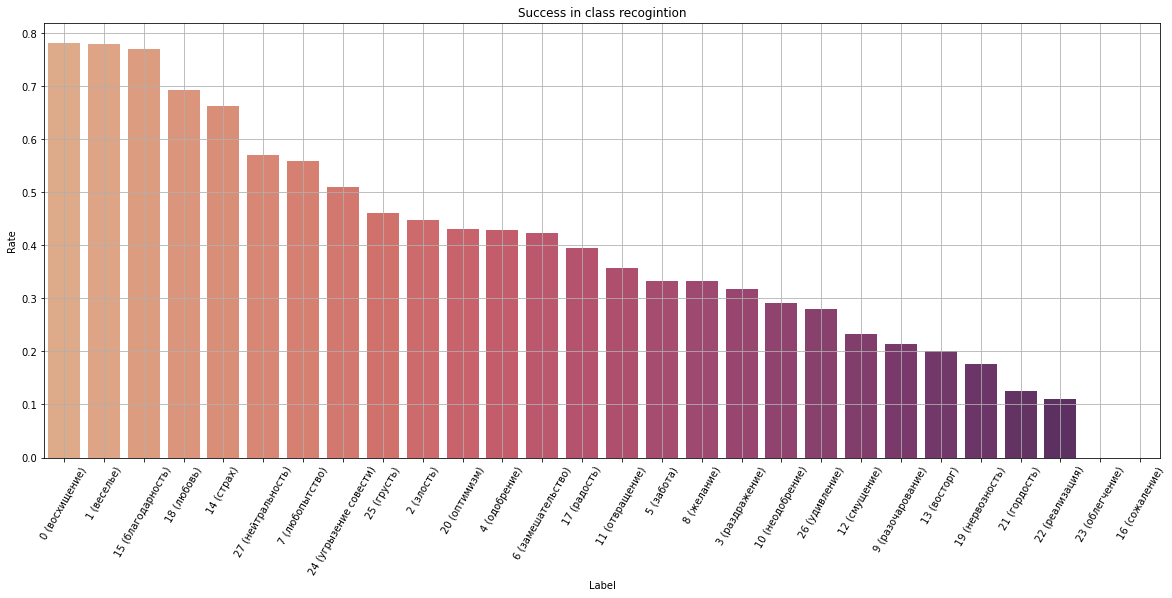

In [136]:
import seaborn as sns 

plt.figure(figsize = (20,8))
plt.title("Success in class recogintion")
sns.barplot(x='Label',
            y="Rate",
            data=labelsuccess, 
            order=labelsuccess.sort_values('Rate', ascending=[False])['Label'],
            palette = 'flare')
plt.xticks(rotation=60)
plt.grid()
plt.show() 